In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import os


In [261]:
!python run_decoding.py

## score functions

In [262]:
def score_GVP(dy, ceil = 2.):
    gvp = (1.0 + (dy/5.0)**2)**0.5 - 1.0
    res = np.clip(gvp, 0., ceil) # if gvp < ceil {gvp} else {ceil};
    return 100.*res


In [286]:
data = "CGM_p77_24h"
diff = "CGMDIFF"+data[3:]

df = pd.read_csv("data/%s.csv"%data, header=None, names=["ts","CGM"])
df["TIR"] = df["CGM"].apply(lambda x: 100.0 if ((x<180) & (x>70)) else 0.0)
df["H70"] = df["CGM"].apply(lambda x: 100.0 if (x<70) else 0.0)
df["H54"] = df["CGM"].apply(lambda x: 100.0 if (x<54) else 0.0)
df["GVP"] = df["CGM"].diff(1).apply(score_GVP)
df["LOG"] = df["CGM"].apply(lambda x: 200.*(np.log(np.clip(x,20,400))/np.log(20)-1))
#df["GV4"] = df["CGM"].diff(1).apply(lambda x: score_GVP(x, 4))
#df["GV8"] = df["CGM"].diff(1).apply(lambda x: score_GVP(x, 8))
#df["GVI"] = df["LOG"].diff(1).apply(lambda x: score_GVP(x, 2))
df["ADV"] = df["CGM"].diff(1).apply(np.abs)
df["LOG_ADV"] = df["LOG"].diff(1).apply(np.abs)
df["SIX"] = df["CGM"].apply(lambda x: 200.*(np.log(np.clip(x,36,216))/np.log(6)-2))
df["SIX_ADV"] = df["SIX"].diff(1).apply(np.abs)
df["SJU"] = df["CGM"].apply(lambda x: 200.*(np.log(np.clip(x,49,343))/np.log(7)-2))
df["SJU_ADV"] = df["SJU"].diff(1).apply(np.abs)
df["SJU_ADV50"] = df["SJU"].diff(1).clip(-50.,50.).apply(np.abs)
df["DIFF"] = pd.read_csv("data/%s.csv"%diff, header=None, index_col=0).values
df["ABS50"] = df["DIFF"].clip(-50.,50.).apply(np.abs)
df["RDV"] = df["DIFF"].apply(lambda x: 10*score_GVP(x, 10)/100)
df.head()


,ts,CGM,TIR,H70,H54,GVP,LOG,ADV,LOG_ADV,SIX,SIX_ADV,SJU,SJU_ADV,SJU_ADV50,DIFF,ABS50,RDV
0,2021-01-01 12:18:40,189.000000,0.0,0.0,0.0,NaN,149.947628,NaN,NaN,185.094942,NaN,138.745020,NaN,NaN,5.993355,5.993355,5.610293
1,2021-01-01 12:23:40,194.993355,0.0,0.0,0.0,56.102927,152.031824,5.993355,2.084196,188.579614,3.484672,141.953644,3.208624,3.208624,-1.993355,1.993355,0.765401
2,2021-01-01 12:28:40,193.000000,0.0,0.0,0.0,7.654013,151.345829,1.993355,0.685996,187.432664,1.146950,140.897553,1.056091,1.056091,5.980000,5.980000,5.589792
3,2021-01-01 12:33:40,198.980000,0.0,0.0,0.0,55.897915,153.383002,5.980000,2.037173,190.838716,3.406052,144.033785,3.136232,3.136232,-5.973333,5.973333,5.579565
4,2021-01-01 12:38:40,193.006667,0.0,0.0,0.0,55.795650,151.348135,5.973333,2.034867,187.436519,3.402196,140.901103,3.132682,3.132682,2.003333,2.003333,0.772807


In [287]:
df["CGM"].diff(1).describe()


count    287.000000
mean      -0.292683
std        8.698582
min      -42.388438
25%       -4.845000
50%       -0.050000
75%        3.991667
max       55.390000
Name: CGM, dtype: float64

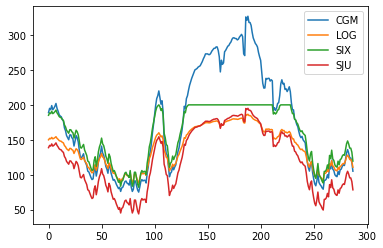

In [265]:
#df[["GV8", "GV4","GVP","GVI"]].plot()
df[["CGM","LOG","SIX","SJU"]].plot()
plt.show()

## Analyse score series

In [296]:
allfiles = glob("data/*/%s*.csv"%data) + glob("data/*/%s*.csv"%diff)

dt = {key:{} for key in df.columns[1:]}

for filepath in allfiles:
    _, keys, filename = filepath.split("/")
    name, _ = filename.split(".")
    tmp = name.split("_")
    tag = keys+"_"+"_".join(tmp[3:6])
    if "hourly" in name or "rolling" in name:
        continue
    if len(tmp) == 6:
        if "DIFF" in name:
            tmp.append("DIFF")
        else:    
            tmp.append("CGM")
    idx = "_".join(tmp[6:])
    #print(tag, idx)
    ds = pd.read_csv(filepath, header=None)
    dt[idx][tag] = ds.values[:,0]
        

In [267]:
{key:len(dt[key]) for key in dt.keys()}


{'CGM': 66,
 'TIR': 30,
 'H70': 1,
 'H54': 1,
 'GVP': 22,
 'LOG': 9,
 'ADV': 22,
 'LOG_ADV': 1,
 'SIX': 22,
 'SIX_ADV': 1,
 'SJU': 22,
 'SJU_ADV': 22,
 'SJU_ADV50': 22,
 'DIFF': 14,
 'ABS50': 14,
 'RDV': 4}

In [268]:
idx = "GVP"
[(pd.DataFrame(dt[idx], index=df.index[1:]) - df[[idx]].iloc[1:,:].values).describe().T[["std"]].rename(columns={'std': idx})for idx in ["GVP"] ]
#{key:len(dt[idx][key]) for key in dt[idx]} 



[                             GVP
 80_1024_1_4_6_2_3_400  60.385648
 80_1024_1_6_7_2_3_400  60.099901
 80_1024_1_3_5_2_3_400  68.371590
 80_1024_1_5_5_2_3_400  53.964959
 80_1024_1_7_3_2_3_400  62.135016
 80_1024_1_5_4_2_3_400  61.395644
 80_1024_1_6_6_2_3_400  63.404068
 80_1024_1_5_6_2_3_400  63.319937
 80_1024_1_6_3_2_3_400  57.810088
 80_1024_1_3_7_2_3_400  63.686537
 80_1024_1_5_7_2_3_400  60.616033
 80_1024_1_4_7_2_3_400  60.061418
 80_1024_1_7_4_2_3_400  69.600012
 80_1024_1_7_7_2_3_400  66.812251
 80_1024_1_6_5_2_3_400  60.483126
 80_1024_1_5_3_2_3_400  64.205906
 80_1024_1_4_4_2_3_400  61.352040
 80_1024_1_6_4_2_3_400  62.314310
 80_1024_1_7_5_2_3_400  62.657339
 80_1024_1_3_6_2_3_400  61.071944
 80_1024_1_4_5_2_3_400  60.375879
 80_1024_1_7_6_2_3_400  61.381844]

In [269]:
tmp = pd.concat([
    (pd.DataFrame(dt[idx], index=df.index) - df[[idx]].values).describe().T[["std"]].rename(columns={'std': idx})
        for idx in ["CGM","TIR","H70","LOG","SJU"] ] + [
    (pd.DataFrame(dt[idx], index=df.index[1:]) - df[[idx]].iloc[1:,:].values).describe().T[["std"]].rename(columns={'std': idx})
        for idx in ["GVP","ADV","SJU_ADV"] ], axis=1)
tmp



,CGM,TIR,H70,LOG,SJU,GVP,ADV,SJU_ADV
80_1024_1_4_6_2_3_400,1.744310e-09,0.002769,NaN,1.428761,2.198428,60.385648,4.539120,3.759606
80_1024_1_4_6_3_3_400,3.093502e-09,42.214358,NaN,NaN,NaN,NaN,NaN,NaN
80_1024_1_4_6_4_3_400,6.789277e-09,49.697770,NaN,NaN,NaN,NaN,NaN,NaN
80_1024_1_6_7_2_3_400,1.690455e-09,10.218053,NaN,1.454999,2.239973,60.099901,4.725422,3.647202
80_1024_1_6_7_3_3_400,3.098646e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
80_1024_1_4_5_3_3_400,3.228228e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80_1024_1_4_5_4_3_400,6.362011e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80_1024_1_7_6_2_3_400,1.639072e-09,5.892556,NaN,NaN,2.284981,61.381844,4.871866,3.643561
80_1024_1_7_6_3_3_400,3.141779e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


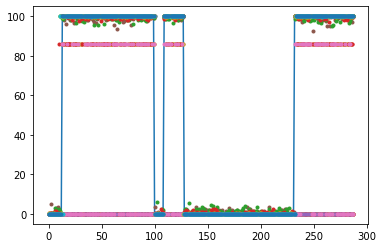

In [270]:
idx = "TIR"
ds = pd.DataFrame(dt[idx], index=df.index)
plt.plot(df[idx])
plt.plot(ds, ".")
plt.show()
#(ds - df[[idx]].values).describe().T, pd.concat([ds,df[idx]], axis =1)


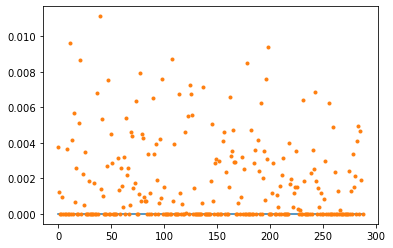

In [271]:
idx = "H70"
ds = pd.DataFrame(dt[idx], index=df.index)
plt.plot(df[idx])
plt.plot(ds, ".")
plt.show()
#(ds - df[[idx]].values).describe().T, pd.concat([ds,df[idx]], axis =1)


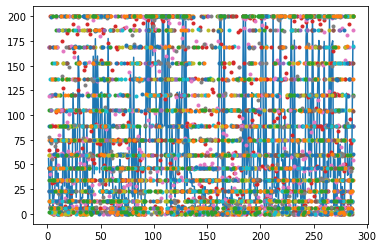

,mean,std,25%,75%,rmse,rel
80_1024_1_5_5_2_3_400,18.407606,53.964959,-13.254629,52.253603,57.018039,0.943377
80_1024_1_6_3_2_3_400,20.685519,57.810088,-8.791822,58.721785,61.399487,1.015869
80_1024_1_5_7_2_3_400,17.573202,60.616033,-13.772071,45.252279,63.111971,1.044202
80_1024_1_7_6_2_3_400,15.353750,61.381844,-14.617548,46.282602,63.272968,1.046866
80_1024_1_4_7_2_3_400,21.052198,60.061418,-12.946621,58.141310,63.644080,1.053006
80_1024_1_7_3_2_3_400,15.846844,62.135016,-15.952218,43.554953,64.123964,1.060946
80_1024_1_4_6_2_3_400,21.760069,60.385648,-12.569703,57.711659,64.186658,1.061983
80_1024_1_3_6_2_3_400,20.221354,61.071944,-7.853665,52.242766,64.332616,1.064398
80_1024_1_4_5_2_3_400,22.940549,60.375879,-14.631531,65.603281,64.587271,1.068611
80_1024_1_7_5_2_3_400,16.103949,62.657339,-16.690115,47.301203,64.693735,1.070373


In [272]:
idx = "GVP"
ds = pd.DataFrame(dt[idx], index=df.index[1:])
plt.plot(df[idx])
plt.plot(ds, ".")
plt.show()
tmp = (ds - df[[idx]].values[1:]).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


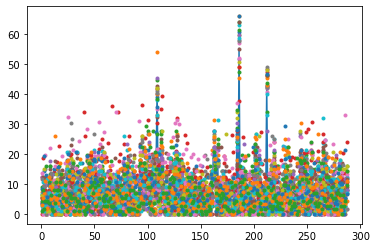

,mean,std,25%,75%,rmse,rel
80_1024_1_5_5_2_3_400,1.488150,4.222337,-1.284488,4.558246,4.476909,0.728612
80_1024_1_4_6_2_3_400,1.712880,4.539120,-1.257517,4.836405,4.851553,0.789585
80_1024_1_6_3_2_3_400,1.870288,4.518673,-1.001783,4.720007,4.890438,0.795914
80_1024_1_4_7_2_3_400,1.763675,4.569141,-1.382834,4.526625,4.897714,0.797098
80_1024_1_7_3_2_3_400,1.379189,4.750077,-1.998468,4.326937,4.946251,0.804997
80_1024_1_6_5_2_3_400,1.891294,4.576743,-1.192387,4.774507,4.952128,0.805954
80_1024_1_6_4_2_3_400,1.649035,4.678610,-1.237512,4.484807,4.960717,0.807351
80_1024_1_7_5_2_3_400,1.374851,4.776053,-2.028581,4.437629,4.969999,0.808862
80_1024_1_6_6_2_3_400,1.405966,4.771517,-1.457929,4.374189,4.974346,0.809569
80_1024_1_5_4_2_3_400,1.776164,4.725383,-1.045635,4.808801,5.048168,0.821584


In [273]:
idx = "ADV"
ds = pd.DataFrame(dt[idx], index=df.index[1:])
plt.plot(df[idx])
plt.plot(ds, ".")
plt.show()
(ds - df[[idx]].values[1:]).describe().T
tmp = (ds - df[[idx]].values[1:]).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


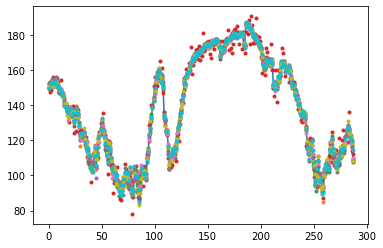

,mean,std,25%,75%,rmse,rel
80_1024_1_5_6_2_3_400,0.013211,1.409526,-0.670744,0.809641,1.409588,0.010205
80_1024_1_6_6_2_3_400,0.052525,1.412583,-0.733868,0.836360,1.413559,0.010234
80_1024_1_7_3_2_3_400,-0.040140,1.420357,-0.745259,0.757491,1.420924,0.010287
80_1024_1_4_6_2_3_400,-0.061590,1.428761,-0.804513,0.715511,1.430088,0.010354
80_1024_1_5_5_2_3_400,-0.002501,1.436706,-0.743567,0.738059,1.436708,0.010401
80_1024_1_6_7_2_3_400,-0.021144,1.454999,-0.811427,0.865232,1.455153,0.010535
80_1024_1_6_4_2_3_400,0.148140,1.448781,-0.690215,0.805979,1.456335,0.010544
80_1024_1_5_4_2_3_400,-0.028663,1.485364,-0.960579,0.788984,1.485640,0.010756
80_1024_1_3_5_2_3_400,-0.108801,4.582171,-3.385775,2.676619,4.583463,0.033183


In [274]:
idx = "LOG"
ds = pd.DataFrame(dt[idx], index=df.index[:])
plt.plot(df[idx])
plt.plot(ds, ".")
plt.show()
tmp = (ds - df[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel") 


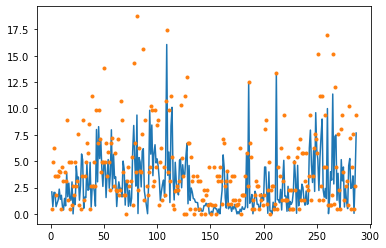

,mean,std,25%,75%,rmse,rel
80_1024_1_6_4_2_3_400,1.414575,2.66512,-0.306153,2.881025,3.017265,1.074963


In [275]:
idx = "LOG_ADV"
ds = pd.DataFrame(dt[idx], index=df.index[1:])
plt.plot(df[idx])
plt.plot(ds, ".")
plt.show()
(ds - df[[idx]].values[1:]).describe().T
tmp = (ds - df[[idx]].values[1:]).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


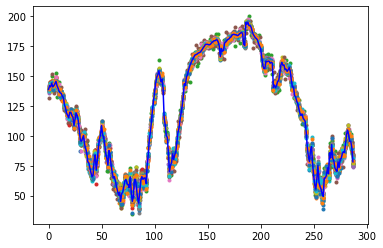

,mean,std,25%,75%,rmse,rel
80_1024_1_7_7_2_3_400,-0.053973,2.094917,-1.112342,1.055701,2.095612,0.017385
80_1024_1_5_7_2_3_400,-0.038903,2.106891,-1.272854,1.012753,2.107250,0.017481
80_1024_1_3_7_2_3_400,-0.059404,2.116021,-1.246350,1.143317,2.116854,0.017561
80_1024_1_5_6_2_3_400,0.020323,2.169977,-1.032661,1.246198,2.170072,0.018002
80_1024_1_6_6_2_3_400,0.080873,2.174666,-1.129834,1.287566,2.176169,0.018053
80_1024_1_7_3_2_3_400,-0.054346,2.184167,-1.155966,1.245636,2.184843,0.018125
80_1024_1_7_5_2_3_400,0.029878,2.194903,-1.244581,1.238987,2.195107,0.018210
80_1024_1_4_6_2_3_400,-0.095452,2.198428,-1.258515,1.100310,2.200499,0.018255
80_1024_1_5_5_2_3_400,-0.004183,2.211723,-1.148358,1.142901,2.211727,0.018348
80_1024_1_6_7_2_3_400,-0.032552,2.239973,-1.249127,1.332019,2.240210,0.018584


In [276]:
idx = "SJU"
ds = pd.DataFrame(dt[idx], index=df.index[:])
plt.plot(ds, ".")
plt.plot(df[idx], "b")
plt.show()
tmp = (ds - df[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")

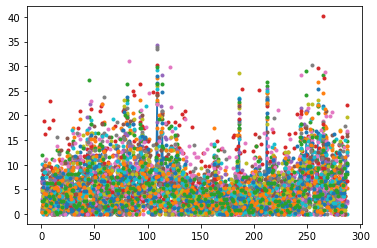

,mean,std,25%,75%,rmse,rel
80_1024_1_3_6_2_3_400,1.077426,3.331649,-1.080936,2.846069,3.501533,0.810323
80_1024_1_3_7_2_3_400,1.115775,3.377484,-1.161538,3.626612,3.557015,0.823162
80_1024_1_6_4_2_3_400,1.217752,3.374638,-0.911993,3.154735,3.587632,0.830248
80_1024_1_5_6_2_3_400,1.109089,3.511764,-0.770487,3.143073,3.682739,0.852257
80_1024_1_7_5_2_3_400,1.202415,3.481914,-1.206211,3.452959,3.683683,0.852476
80_1024_1_6_6_2_3_400,1.238204,3.490845,-0.837832,3.263654,3.703937,0.857163
80_1024_1_7_4_2_3_400,1.085755,3.548086,-1.028846,3.327254,3.710496,0.858681
80_1024_1_5_4_2_3_400,1.246166,3.513079,-0.701172,3.376422,3.727553,0.862628
80_1024_1_6_5_2_3_400,1.244435,3.535417,-0.979508,3.524281,3.748039,0.867369
80_1024_1_7_7_2_3_400,0.992441,3.616712,-1.126369,3.316887,3.750406,0.867917


In [277]:
idx = "SJU_ADV"
ds = pd.DataFrame(dt[idx], index=df.index[1:])
plt.plot(df[idx])
plt.plot(ds, ".")
plt.show()
tmp = (ds - df[[idx]].values[1:]).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")



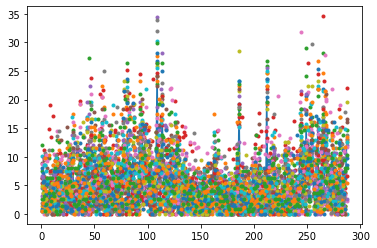

,mean,std,25%,75%,rmse,rel
80_1024_1_3_6_2_3_400,1.064452,3.319772,-1.018070,3.045369,3.486251,0.806786
80_1024_1_3_7_2_3_400,1.115761,3.378502,-1.157328,3.624450,3.557977,0.823385
80_1024_1_6_4_2_3_400,1.218076,3.374560,-0.907509,3.151391,3.587669,0.830256
80_1024_1_5_6_2_3_400,1.109092,3.511763,-0.770518,3.143053,3.682739,0.852257
80_1024_1_7_5_2_3_400,1.202425,3.481907,-1.206175,3.453136,3.683680,0.852475
80_1024_1_6_6_2_3_400,1.238202,3.490851,-0.837812,3.263696,3.703941,0.857164
80_1024_1_7_4_2_3_400,1.085750,3.548069,-1.028534,3.327505,3.710478,0.858677
80_1024_1_5_4_2_3_400,1.237065,3.518846,-0.634879,3.403761,3.729960,0.863185
80_1024_1_6_5_2_3_400,1.244422,3.535425,-0.979612,3.524289,3.748042,0.867370
80_1024_1_7_7_2_3_400,0.992433,3.616725,-1.126373,3.316919,3.750416,0.867919


In [278]:
idx = "SJU_ADV50"
ds = pd.DataFrame(dt[idx], index=df.index[1:])
plt.plot(df[idx])
plt.plot(ds, ".")
plt.show()
tmp = (ds - df[[idx]].values[1:]).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


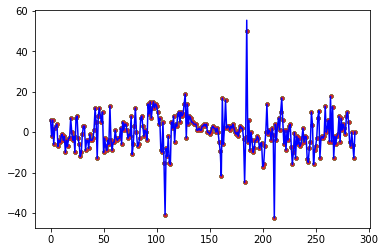

,mean,std,25%,75%,rmse,rel
80_1024_1_5_4_2_3_50,-0.018715,0.317609,-3.652390e-10,2.639542e-10,0.31816,0.051958
80_1024_1_4_6_2_3_50,-0.018715,0.317609,-2.797620e-10,2.606424e-10,0.31816,0.051958
80_1024_1_6_6_2_3_50,-0.018715,0.317609,-2.987726e-10,2.465654e-10,0.31816,0.051958
80_1024_1_4_5_2_3_50,-0.018715,0.317609,-2.711040e-10,3.000089e-10,0.31816,0.051958
80_1024_1_4_7_2_3_50,-0.018715,0.317609,-2.508037e-10,2.540257e-10,0.31816,0.051958
80_1024_1_6_5_2_3_50,-0.018715,0.317609,-2.712941e-10,2.657414e-10,0.31816,0.051958
80_1024_1_5_3_2_3_50,-0.018715,0.317609,-2.934223e-10,2.656684e-10,0.31816,0.051958
80_1024_1_4_4_2_3_50,-0.018715,0.317609,-2.989663e-10,3.060250e-10,0.31816,0.051958
80_1024_1_6_7_2_3_50,-0.018715,0.317609,-2.874216e-10,3.055174e-10,0.31816,0.051958
80_1024_1_6_3_2_3_50,-0.018715,0.317609,-2.811529e-10,2.664446e-10,0.31816,0.051958


In [279]:
idx = "DIFF"
ds = pd.DataFrame(dt[idx], index=df.index[:])
plt.plot(ds, ".")
plt.plot(df[idx], "b")
plt.show()
tmp = (ds - df[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].abs().mean()
tmp.sort_values("rel")

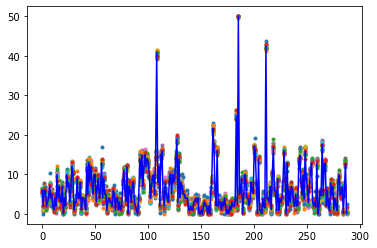

,mean,std,25%,75%,rmse,rel
80_1024_1_6_5_2_3_50,0.036819,0.672307,-0.396156,0.489416,0.673314,0.110295
80_1024_1_5_4_2_3_50,-0.001424,0.684780,-0.543579,0.455763,0.684782,0.112173
80_1024_1_6_4_2_3_50,-0.012948,0.701494,-0.502331,0.486377,0.701613,0.114931
80_1024_1_4_5_2_3_50,0.060898,0.701743,-0.412495,0.531478,0.704381,0.115384
80_1024_1_6_6_2_3_50,-0.047273,0.703800,-0.513177,0.398831,0.705386,0.115549
80_1024_1_4_7_2_3_50,0.008913,0.714016,-0.484133,0.549617,0.714071,0.116971
80_1024_1_5_7_2_3_50,0.043795,0.725192,-0.478317,0.546349,0.726513,0.119009
80_1024_1_4_6_2_3_50,0.076946,0.737895,-0.415187,0.618969,0.741896,0.121529
80_1024_1_6_3_2_3_50,0.115414,0.735779,-0.423446,0.622688,0.744776,0.122001
80_1024_1_5_6_2_3_50,-0.076337,0.742530,-0.610667,0.405322,0.746444,0.122274


In [297]:
idx = "ABS50"
ds = pd.DataFrame(dt[idx], index=df.index[:])
plt.plot(ds, ".")
plt.plot(df[idx], "b")
plt.show()
tmp = (ds - df[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


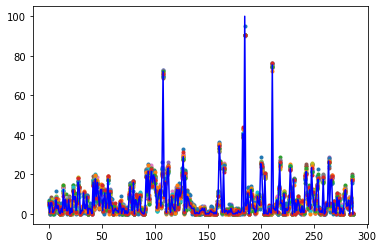

,mean,std,25%,75%,rmse,rel1,rel
80_1024_1_6_5_2_3_50,0.012028,1.064817,-0.422715,0.541328,1.064885,0.062678,0.152348
80_1024_1_5_4_2_3_50,-0.052563,1.067105,-0.597426,0.536535,1.068399,0.062885,0.152850
80_1024_1_6_6_2_3_50,-0.066429,1.083001,-0.622067,0.456053,1.085036,0.063864,0.155230
80_1024_1_4_5_2_3_50,0.064162,1.093409,-0.423116,0.644330,1.095290,0.064467,0.156698
80_1024_1_6_4_2_3_50,-0.082066,1.104496,-0.607120,0.479565,1.107540,0.065188,0.158450
80_1024_1_4_7_2_3_50,-0.003791,1.119738,-0.503251,0.599495,1.119744,0.065907,0.160196
80_1024_1_6_7_2_3_50,0.076961,1.129509,-0.403043,0.691503,1.132128,0.066636,0.161968
80_1024_1_6_3_2_3_50,0.103379,1.131035,-0.507807,0.635176,1.135750,0.066849,0.162486
80_1024_1_5_7_2_3_50,0.010072,1.137835,-0.562458,0.590237,1.137880,0.066974,0.162791
80_1024_1_4_6_2_3_50,0.055129,1.175032,-0.486352,0.684173,1.176325,0.069237,0.168291


In [298]:
idx = "RDV"
ds = pd.DataFrame(dt[idx], index=df.index[:])
plt.plot(ds, ".")
plt.plot(df[idx], "b")
plt.show()
tmp = (ds - df[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel1"] = tmp["rmse"]/(10+df[idx].mean())
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


6.989837777822797